In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sb

from scipy.interpolate import LSQUnivariateSpline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1

### a

In [2]:
Data = pd.read_csv('data/strongdrink.txt')

In [3]:
X = Data[['alco','malic','tot_phen','color_int']]
y = Data['cultivar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)
LogReg = LogisticRegression(random_state=20, solver='lbfgs',multi_class='multinomial', max_iter=5000)
result = LogReg.fit(X_train, y_train)
y_pred = result.predict(X_test)
MSE_vec_bs = ((y_test != y_pred) ** 2).mean()
print('The intercepts for j=1,2 are', result.intercept_[0:2],'\nThe coefficients for j=1,2 are\n', result.coef_[0:2])
print(classification_report(y_test, y_pred))
print('MSE for test set is', MSE_vec_bs)

The intercepts are [-24.02761653  22.7807325 ] 
The coefficients are
 [[ 1.70173443 -0.26578756  1.22410094  0.02250699]
 [-1.46629729 -0.33295144  0.66355615 -0.92268168]]
             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

MSE for test set is 0.045454545454545456


The most accurately predicted category is j=3, which is not the one with the most observations (j=2).

### b

In [4]:
Xvals = X.values
N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE_vec = np.zeros(N_loo)
yvals = y.values
error = 0
for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    error += int((y_test!=y_pred))
    MSE_vec[test_index] = (y_test != y_pred) ** 2
error_rate = error/N_loo
MSE_loo = MSE_vec.mean()
print('The test has the error rate =', error_rate,
      'and estimate MSE loocv =', MSE_loo)

The test has the error rate = 0.13636363636363635 and estimate MSE loocv = 0.13636363636363635


As is shown above, the error rate in this part is a little higher than part(a).

### c

In [5]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True, random_state=10)
kf.get_n_splits(Xvals)
MSE_vec_kf = np.zeros(4)
yvals = y.values
error = 0
k_ind = int(0)
for train_index, test_index in kf.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    error += (y_test!=y_pred).mean()
    MSE_vec_kf[k_ind] = ((y_test != y_pred) ** 2).mean()
    k_ind += 1
error_rate = error/k_ind
MSE_kf = MSE_vec_kf.mean()
print('The test has the error rate =', error_rate,
      'and estimate MSE loocv =', MSE_kf)

The test has the error rate = 0.17045454545454544 and estimate MSE loocv = 0.17045454545454544


As is shown above, the error rate in this part is a little higher than part(a) and part(b).

## 2

### a

In [6]:
Cool = pd.read_csv('data/CoolIndex.txt', names = ['age','cool index'])

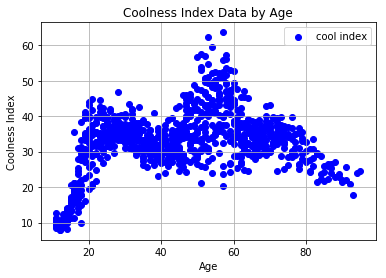

In [7]:
fig,ax = plt.subplots()
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Data by Age')
ax.grid()
ax.legend()
plt.show()

### b

In [8]:
bins = pd.cut(Cool['age'],(11, 22, 40, 59, 77, 96), right=False)
Cool['age range'] = bins
Dummies = pd.get_dummies(Cool['age range'])
Dummies.columns = ['range 1','range 2','range 3','range 4','range 5']
Cool = pd.concat([Cool,Dummies],axis=1)
Up = [11, 22, 40, 59, 77]
Down = [22, 40, 59, 77, 96]

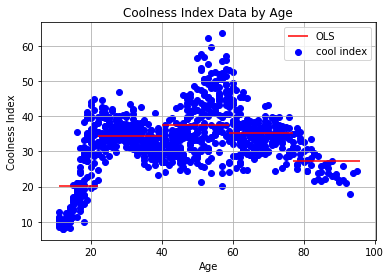

In [9]:
reg = sm.OLS(Cool['cool index'],Cool[['range 1','range 2','range 3','range 4','range 5']])
results = reg.fit()
Coef = np.array(results.params.values)
Cool['predict'] = 0.0
Cool['predict'] = results.predict(Cool[['range 1','range 2','range 3','range 4','range 5']])
fig,ax = plt.subplots()
ax.hlines(Coef,Up,Down,color='r',label = 'OLS')
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Data by Age')
ax.grid()
ax.legend()
plt.show()

In [10]:
print('The predicted coolness index of a 73-year-old person from the stepwise function is', results.predict([0,0,0,1,0])[0])

The predicted coolness index of a 73-year-old person from the stepwise function is 35.22540004024275


### c

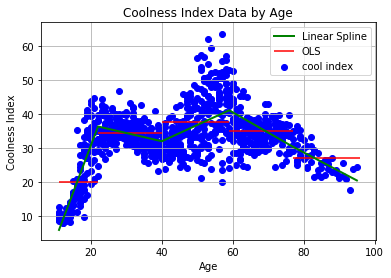

In [11]:
X = np.arange(11,96)
def get_y(x):
    y = np.zeros(x.size)
    for i in range(x.size):
        number = x[i]
        y[i] = Cool['cool index'][Cool['age']==number].mean()
    return y
y = get_y(X)
LSQ = LSQUnivariateSpline(X,y,t=[22,40,59,77],k=1)
fig,ax = plt.subplots()
ax.hlines(Coef,Up,Down,color='r',label = 'OLS')
ax.plot(Cool['age'],LSQ(Cool['age']),color='g',label = 'Linear Spline',lw=2)
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Data by Age')
ax.grid()
ax.legend()
plt.show()

In [12]:
print('The predicted coolness index of a 73-year-old person from the linear spline is', LSQ(73))

The predicted coolness index of a 73-year-old person from the linear spline is 32.86784862349653


### d

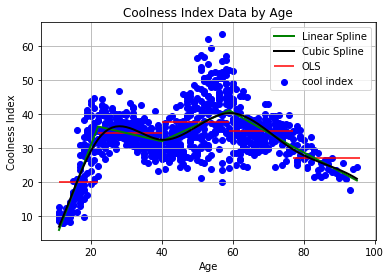

In [13]:
LSQ3 = LSQUnivariateSpline(X,y,t=[22,40,59,77],k=3)
fig,ax = plt.subplots()
ax.hlines(Coef,Up,Down,color='r',label = 'OLS')
ax.plot(Cool['age'],LSQ(Cool['age']),color='g',label = 'Linear Spline',lw=2)
ax.plot(Cool['age'],LSQ3(Cool['age']),color='black',label = 'Cubic Spline',lw=2)
ax.scatter(Cool['age'],Cool['cool index'],color = 'b')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index Data by Age')
ax.grid()
ax.legend()
plt.show()

In [14]:
print('The predicted coolness index of a 73-year-old person from the cubic spline is', LSQ3(73))

The predicted coolness index of a 73-year-old person from the cubic spline is 32.642301066279764
